# Time Series Linear Model

In [141]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
import sys
sys.path.append('..')

In [143]:
import statslib as stb

import statsmodels.api as sm

import pandas as pd
from copy import deepcopy
import matplotlib as mpl
import matplotlib.pyplot as plt

figsize = (8*1.6, 8)

In [144]:
import warnings
warnings.filterwarnings("ignore")

# Data Set

In [145]:
stb.datasets.uschange.df.head()

,Consumption,Income,Production,Savings,Unemployment
date,,,,,
1970-03-31,0.615986,0.972261,-2.452700,4.810312,0.9
1970-06-30,0.460376,1.169085,-0.551525,7.287992,0.5
1970-09-30,0.876791,1.553271,-0.358708,7.289013,0.5
1970-12-31,-0.274245,-0.255272,-2.185455,0.985230,0.7
1971-03-31,1.897371,1.987154,1.909734,3.657771,-0.1


In [146]:
stb.datasets.uschange.desc

[('consumption', 'percentage change in us consumption'),
 ('production', 'precentage change in inudstrial production'),
 ('savings', 'percentage change in personal savings'),
 ('unemployment',
  'changes in the unemployment rate (as this is already a percentage)')]

In [147]:
df = stb.datasets.uschange.df.reset_index();
df = stb.utils.dframe.to_pd_todatetime(df, 'date', day_only=True)
df.set_index('date', inplace=True)

# Stationarity:

In [148]:
y = df.Consumption

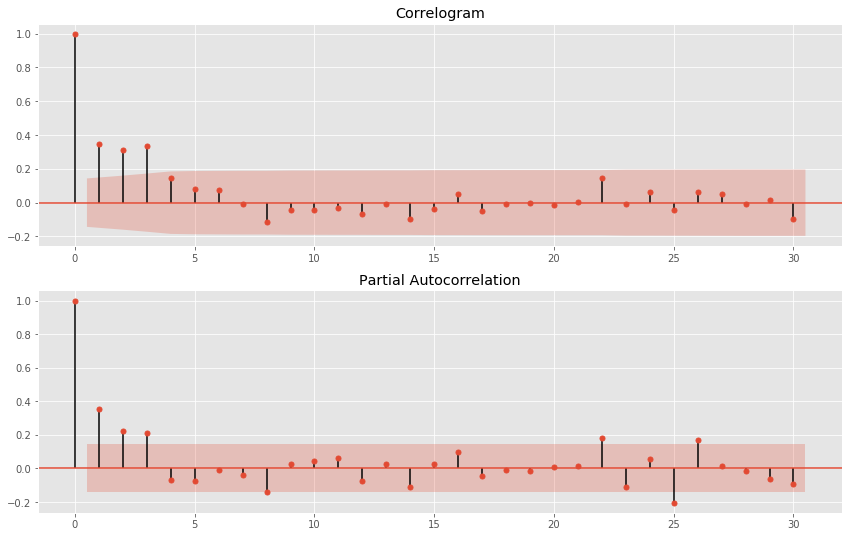

In [149]:
stb.stat_plots.plot_acf_pcf(y)

### p-value

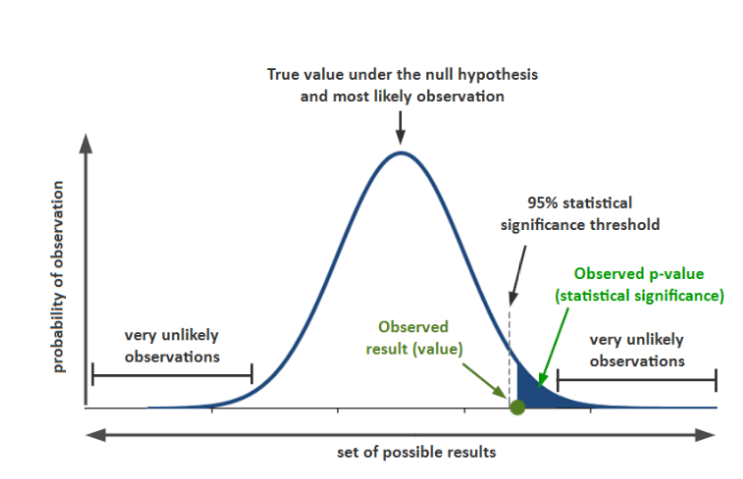

In [150]:
stb.stat_tests.test_adf(y)

H0: unit root present in the time series

Results of Dickey-Fuller Test:
Test Statistic                  -4.522487
p-value                          0.000179
#Lags Used                       2.000000
Number of Observations Used    184.000000
Critical Value (1%)             -3.466398
Critical Value (5%)             -2.877380
Critical Value (10%)            -2.575214
dtype: float64

p-value 0.0002 is less alpha 0.01 => Reject H0


In [151]:
stb.stat_tests.test_kpss(y)

H0: observable time series is stationary around a deterministic trend

Results of KPSS Test:
Test Statistic            0.223319
p-value                   0.100000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Can NOT reject H0


In [152]:
X = stb.datasets.uschange.df.drop('Consumption', axis=1)

# Design Matrix

## Intercept

*The intercept is represented as `const`*. 

The interpretation of the intersept requires, that the situation "all the covariates attain 0 " makes sense.

In general you should have a very strong reason to **not** to include intercept.

In [153]:
f = stb.transforms.identical()
g = stb.transforms.identical()
gs = [g]*X.shape[1]

In [154]:
DM = stb.DesignMatrix(y=y, X=X, f=f, gs=gs, add_const=True)

In [155]:
DM.dm.head()

,y,v,const,g1,g2,g3,g4
t,,,,,,,
1970-03-31,0.615986,0.615986,1.0,0.972261,-2.452700,4.810312,0.9
1970-06-30,0.460376,0.460376,1.0,1.169085,-0.551525,7.287992,0.5
1970-09-30,0.876791,0.876791,1.0,1.553271,-0.358708,7.289013,0.5
1970-12-31,-0.274245,-0.274245,1.0,-0.255272,-2.185455,0.985230,0.7
1971-03-31,1.897371,1.897371,1.0,1.987154,1.909734,3.657771,-0.1


In [156]:
DM.names

{'v': 'Consumption',
 'g1': 'Income',
 'g2': 'Production',
 'g3': 'Savings',
 'g4': 'Unemployment',
 'const': 'const'}

,Consumption,Income,Production,Savings,Unemployment
count,187.000000,187.000000,187.000000,187.000000,187.000000
mean,0.746471,0.717627,0.508060,1.222319,0.007487
std,0.655349,0.931356,1.544829,13.667434,0.375238
min,-2.274110,-4.265250,-6.851039,-68.788267,-0.900000
25%,0.419777,0.337765,0.055683,-4.217823,-0.200000
50%,0.772144,0.723721,0.657928,1.280017,0.000000
75%,1.089752,1.165022,1.305724,6.650723,0.100000
max,2.318295,4.536510,4.149574,50.757962,1.400000


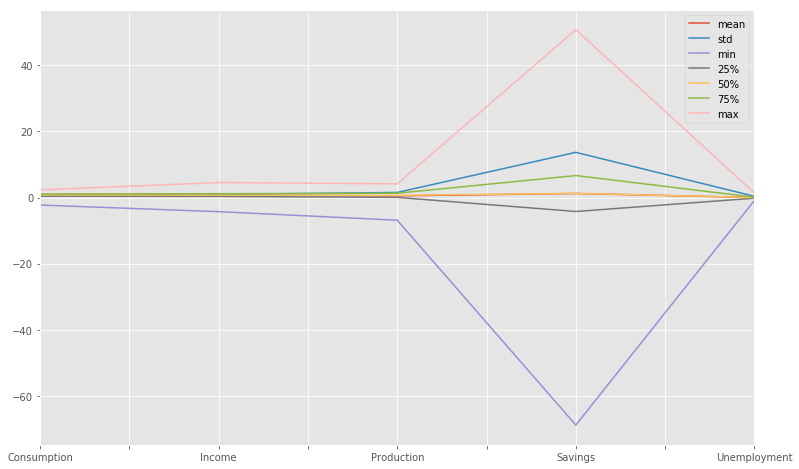

In [157]:
DM.describe()

## Data and transformations

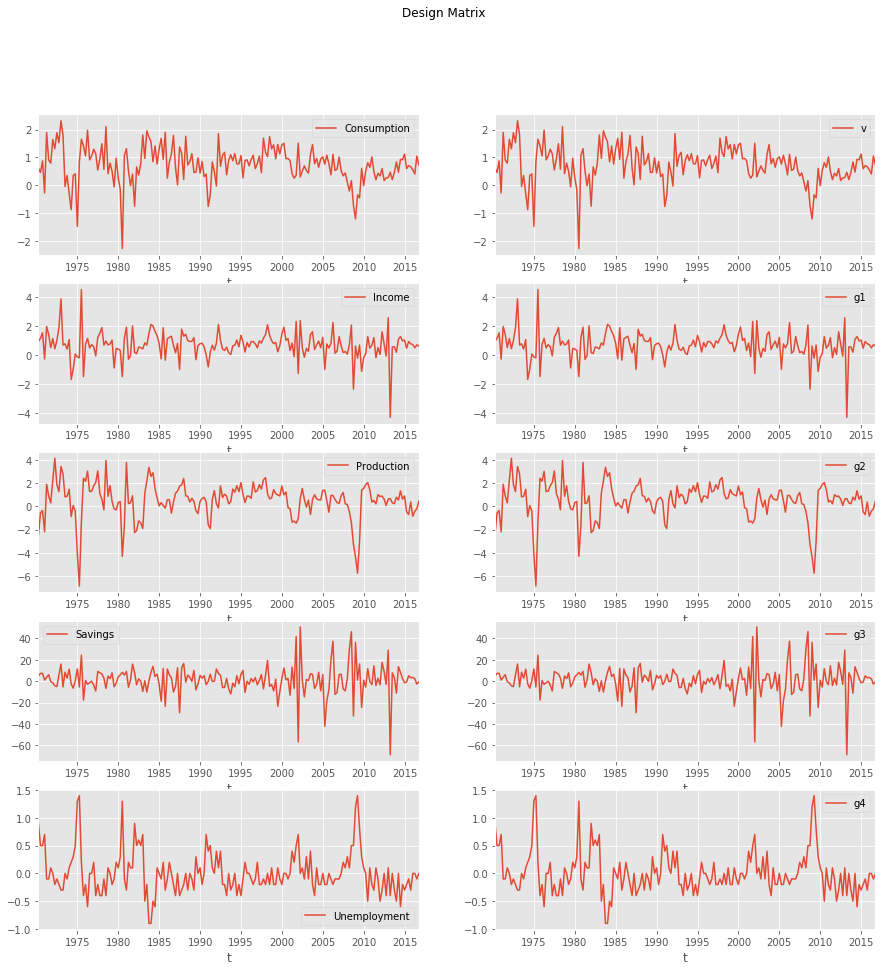

In [158]:
DM.plot()

## Functinal relationship (lowess)

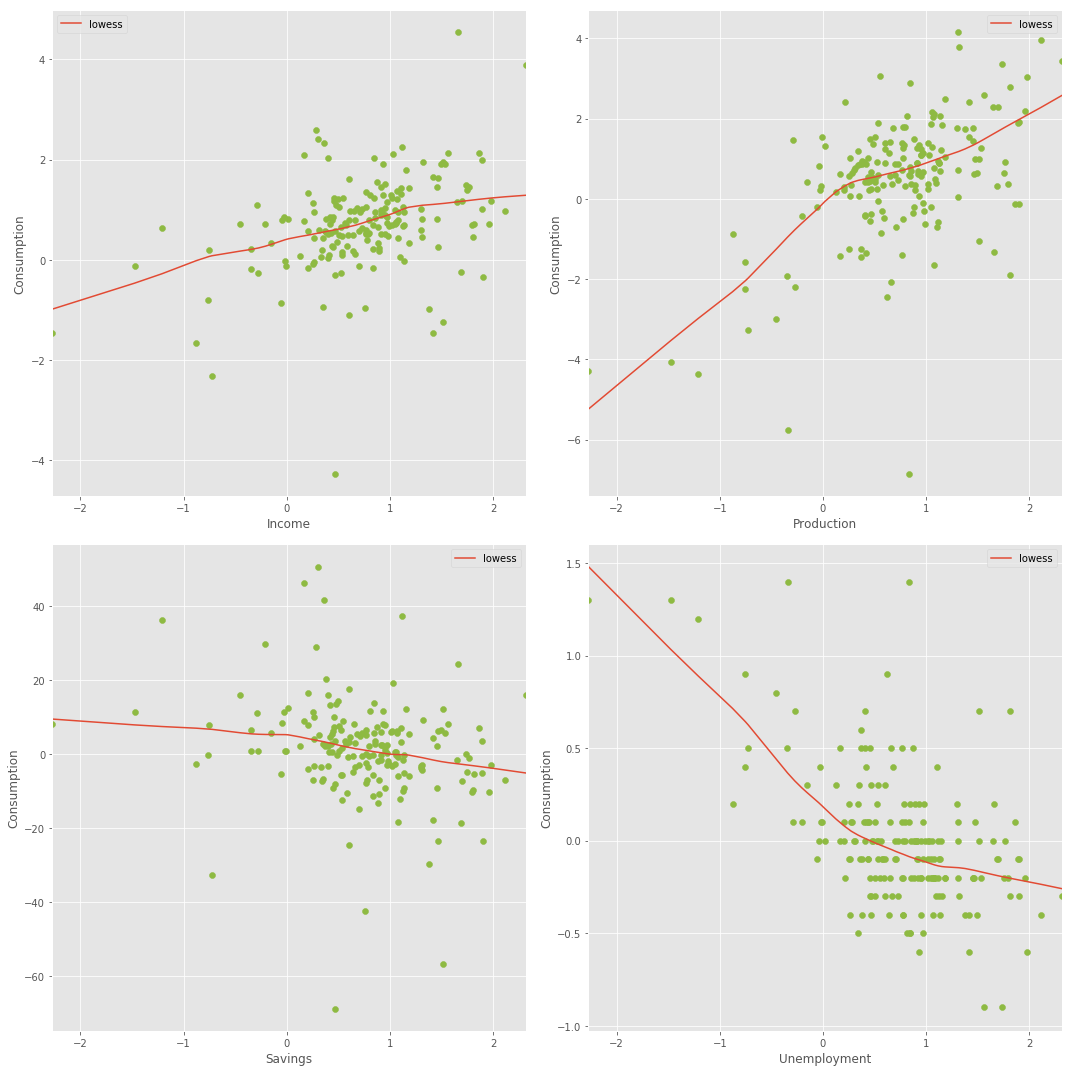

In [159]:
DM.plot_scatter_lowess()

## Lagged relationship

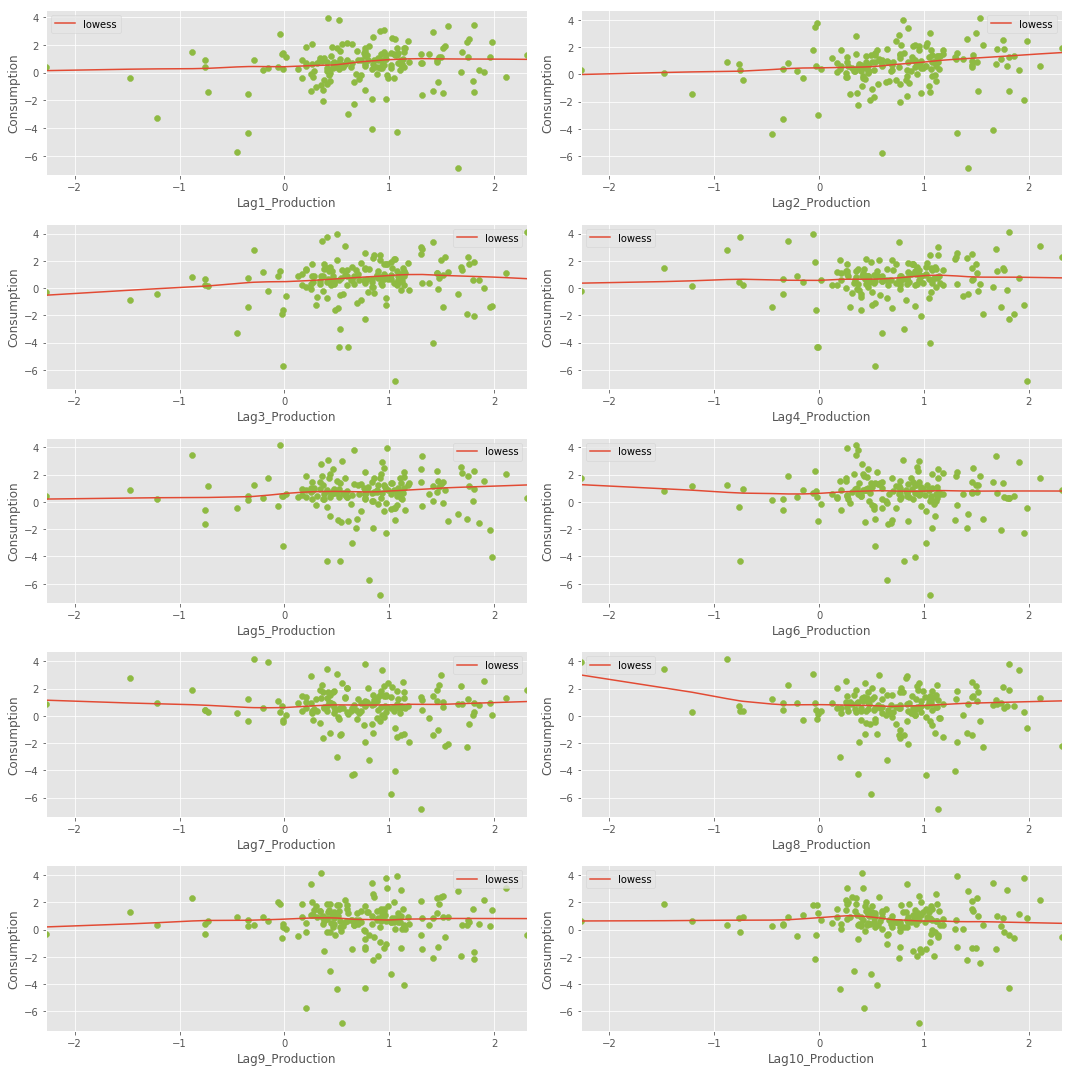

In [160]:
DM.plot_dependent_vs_covariage_lag('Production', 10)

# General Linear Regression

$$
y_t = \beta_0 + \beta_1x^1_t + \beta_2x^2_t + \ldots + \beta_kx^k_t + \varepsilon_t
$$

The coefficients measure the *marginal effects* of the prefictor variables.

## Gauss Markov theorem

For an additive linear model and under the "standard" GM assumptions that the errors are uncorrelated and homoscedastic with expectation value zero, the Ordinary Least Squares (OLS) estimator has the lowest sampling variance within the class of linear unbiased estimators.

BLUE: best linear unbiased estimators

## Gauss Markov assumptions

Let $e_i=\hat{y}_t - y_t$ be the fitted residuals. 



Then we can discuss the following assumptions:

\begin{align*}
1. \quad &E[e_i, e_j] = 0 \quad \text{for $i \neq j$} \\
2. \quad & Var(e_i, e_j) = \sigma^2 < \infty, \quad \forall i \\
3. \quad & Cov(e_i, e_j) = 0, \quad \forall i \neq j
\end{align*}

1: $\to$ unbiaseness  
2,3: $\to$ lowest sampling variance

If 2 and 3 are violated, then we need heteroscedasticity-consistent (Huber-White) standard errors: 
* `cov_type` argument in `sm.OLS` calibrator

***
Normality: 

$$
4. \quad e_i  \text{ ~ } N(0, \sigma^2)
$$

it's useful to have the errors being normally distributed with a constant variance $\sigma^2$ in order to easily produce prediction intervals

***

NOT a random nature of the covariates:  we assume that each predictor is NOT a random.

$$
E[x _i| e ] = 0
$$

If it's violated: the estimated coefficients are not unbiased any more!

***

* Are we interested only in estmiating location parameters (i.e. model coefficients?)
* Are we also interested in estimating valid variances and standard errors of those estimated location parameters?
* Are we limiting ourselves to unbiased variance estimators, or are consistent estimators sufficient?
* If we are limiting ourselves to unibased estimators of location parameters, do they need to be those with minimum variance?

# Grid Search for model specifications

When fittind models, it is possible to increase the likelihood by adding parameters, but doing so may resut in overfitting. Both AIC, AICc and BIC attempt to resolve this problem by introducing a penalty term for the number of parameters in the model; the penalty term is larger in BIC than in AIC

### Information criterions

Likelihood function:
$$
L = p (x | \hat{\theta}, Model)
$$

### Akaike information criterion
$$
AIC = 2k - 2\ln(L)
$$


### Akaike with correction for small sample sizes

$$
AICc = AIC + \dfrac{2k^2 + 2k}{n-k-1}
$$

$ \\ $

*Hirotugu Akaike 1971*

### Bayesian information criterion

$$
BIC = k \ln(n) - 2\ln(L)
$$


where 
* $L$ - is maximum of the likelihood function
* $k$ - number of parameters estimated
* $n$ - number of data points

In [161]:
from itertools import product

from functools import partial
powerset = partial(stb.utils.common.powerset, skip_empty_set=True)

nms = [DM._inv_names.get(k) for k in DM.endog_names]
grid = product(['const'], powerset(nms))
results = []
for elem in grid:
    try:
        c, v = elem
        nm = [c] + list(v)
        gc = stb.GeneralCalibrator(sm.OLS, dict())
        nDM = deepcopy(DM)
        nDM.gX = nDM.gX[nm]
        gm = stb.GeneralModel(gc, nDM)
        gm.fit(range(DM.dm.shape[0]))
        results.append([elem, gm.fitted.bic, nm])
    except Exception as e:
        print(e.args[0])
        continue
pd.DataFrame(results, columns=['elem', 'metric', 'config']).sort_values(
    by=['metric'], ascending=True)[['config', 'metric']]

,config,metric
12,"[const, g1, g3, g4]",133.513313
10,"[const, g1, g2, g3]",134.140518
14,"[const, g1, g2, g3, g4]",135.540525
5,"[const, g1, g3]",149.649140
11,"[const, g1, g2, g4]",298.443878
6,"[const, g1, g4]",300.448641
4,"[const, g1, g2]",302.250964
13,"[const, g2, g3, g4]",307.233988
7,"[const, g2, g3]",309.434068
8,"[const, g2, g4]",312.078289


# Cross-Validation

## Test | Train data split

In [162]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=6)
splits = [(train_idx, test_idx) for train_idx, test_idx in tscv.split(DM.dm.index)]

## Metric

In [163]:
metric = stb.metrics.mean_absolute_error

### Run

CV_error: 0.4189 +/- 0.0788


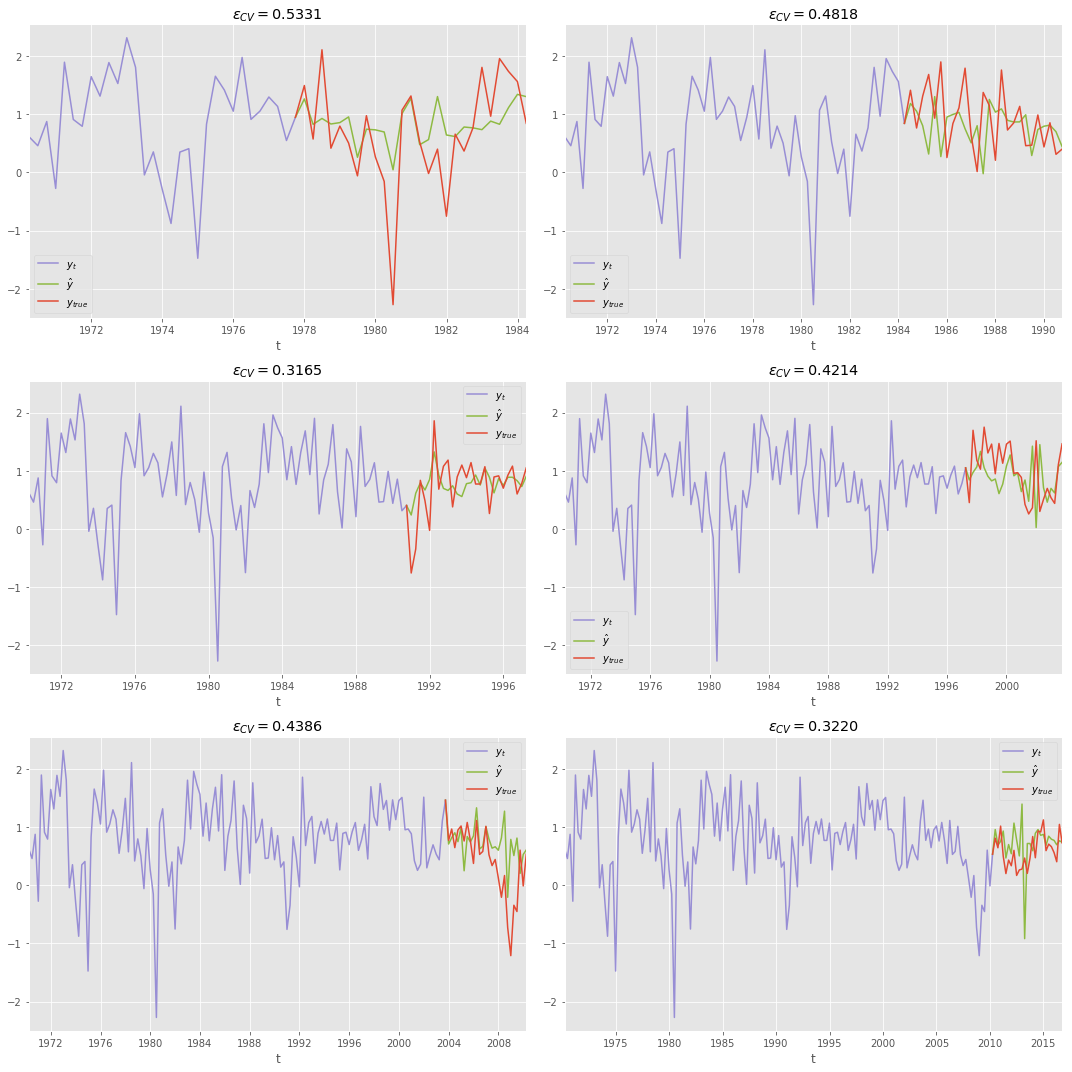

In [164]:
specification = ['const', 'g1']

gc = stb.GeneralCalibrator(sm.OLS, dict())
nDM = deepcopy(DM)

nDM.gX = nDM.gX[specification]
gm = stb.GeneralModel(gc, nDM)
cv = stb.CrossValidation(gm, splits, metric)
cv_m, cv_std = cv.run()

# Final calibration

In [165]:
gc = stb.GeneralCalibrator(sm.OLS, dict())

nDM = deepcopy(DM)

nDM.gX = nDM.gX[specification]

gm = stb.GeneralModel(gc, nDM)

gm.fit(range(DM.n))

gm.forecast(range(DM.n))

print(gm.fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      v   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     34.98
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           1.58e-08
Time:                        14:24:18   Log-Likelihood:                -169.62
No. Observations:                 187   AIC:                             343.2
Df Residuals:                     185   BIC:                             349.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5451      0.056      9.789      0.0

* `F-statistic`: $H_0: \text{regression is not overall significant}$
* `t-statistic`: $H_0: \text{coefficient =0}$
* `R-squared`: $corr(\hat{y}, y)^2$
* `Adj. R-squared`: $\text{$R^2$ adjusted for number of predictors}$
* `std err`: $s/\sqrt(n)$
* `cond no`: measure of multicollinearity
* `Durbin-Watson`: measure of residual serial correlation: value 2 means no serial correlation
* `Jarque-Bera`: for normally distributed residuals

*Breusch Pagan Test for homoscedasticity*

In [166]:
stb.stat_tests.test_breusch_pagan(gm.residuals, gm.fitted.model.exog)

H0: series is homoskedastic

Results of BP Test:
Lagrange multiplier statistic    11.880019
p-value                           0.000567
f-value                          12.550273
f p-value                         0.000501
dtype: float64

p-value 0.0006 is less alpha 0.01 => Reject H0


### Multicollinearity

* If there is high correlation (close to but not equal to +1 or -1), then the estimation of the regression coefficients is computationally difficult
* Uncertainty accosiated with individual coefficients will be large
* Statistical tests on regression coefficients are unreliable
* Not possible to make accurate statemantes about the contribution of each separate predicor to the forecast
* Forecasts will be unreliable if the values of the future predictors are outside the range of the historical values of the predictors

**However**:

if you are using good statistical software, if you are not interested in the speciffic contributions of each predictor, and if the future values of your predictor variables are within their historical ranges, there is nothing to worry about — multicollinearity is not a problem except when there is perfect correlation.


# Predictions and confidence interval

*  we need normality assumption to hold
*  confidence interval:
$$
\hat{y} \pm t_{n-k-1, \alpha / 2}  \text{ std.error.fit}
$$

* prediction interval:
    - wider than confidence interval
    - two sources of errors:   
        - using *estimators* of coefficients
        - error term

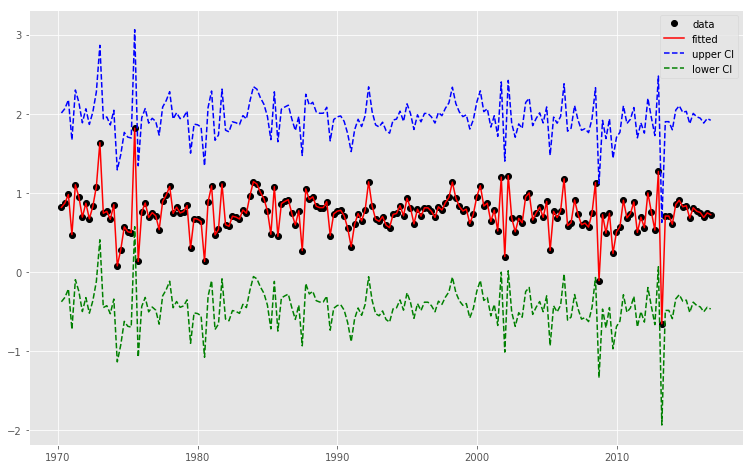

In [167]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

prstd, iv_l, iv_u = wls_prediction_std(gm.fitted) #<---prediction interval

fig, ax = plt.subplots(figsize=figsize)
x = gm.y_hat.index
y = gm.y_hat
y_true =  DM.dm.loc[x]['y']
ax.plot(x, y, 'ko', label="Data")
# ax.plot(x, y_true, 'b-', label="True")
ax.plot(x, gm.fitted.fittedvalues, 'r', label="Predicted")
ax.plot(x, iv_u, 'b--')
ax.plot(x, iv_l, 'g--')
legend = ax.legend(['data','fitted', 'upper CI', 'lower CI'],loc="best")

# Diagnostics

## Plots

* standardized residuals plot $\to$ $E[e_i]=0$ and $Var(e_i) < \infty$
* histogram of residuals $\to$ $e_i \text{ ~ } N(0, \sigma^2)$
* QQ-plot of residuals $\to$ $e_i \text{ ~ } N(0, \sigma^2)$
* correlogram of residuals (ACF): $\to$ *residual information left in residuals*
* residuals vs. fitted values:  $\to$ $Var[e_i]=\sigma^2=const$ (homoskedasticity)
* standardized residuals vs. each of covariates: $E[e|x]=0$

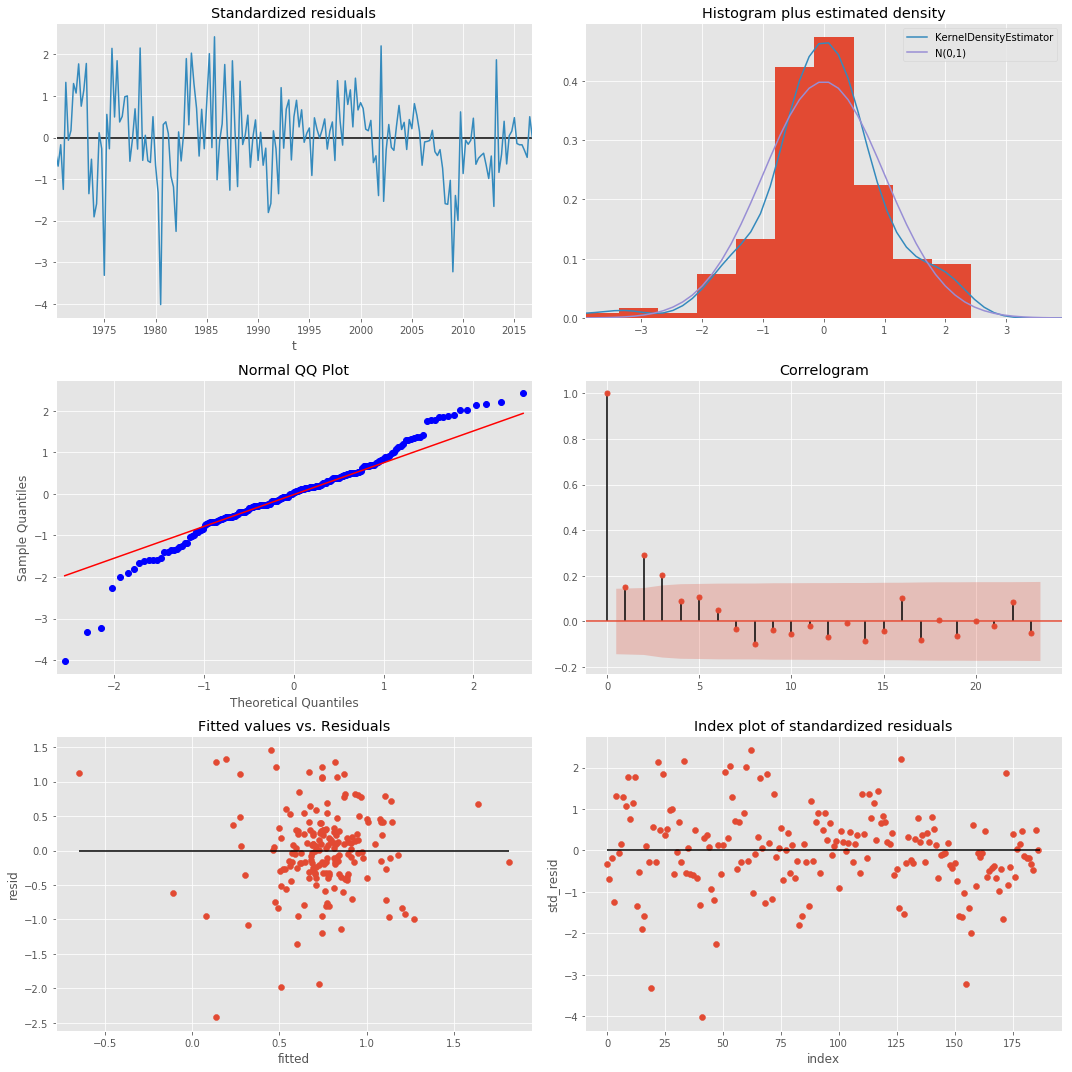

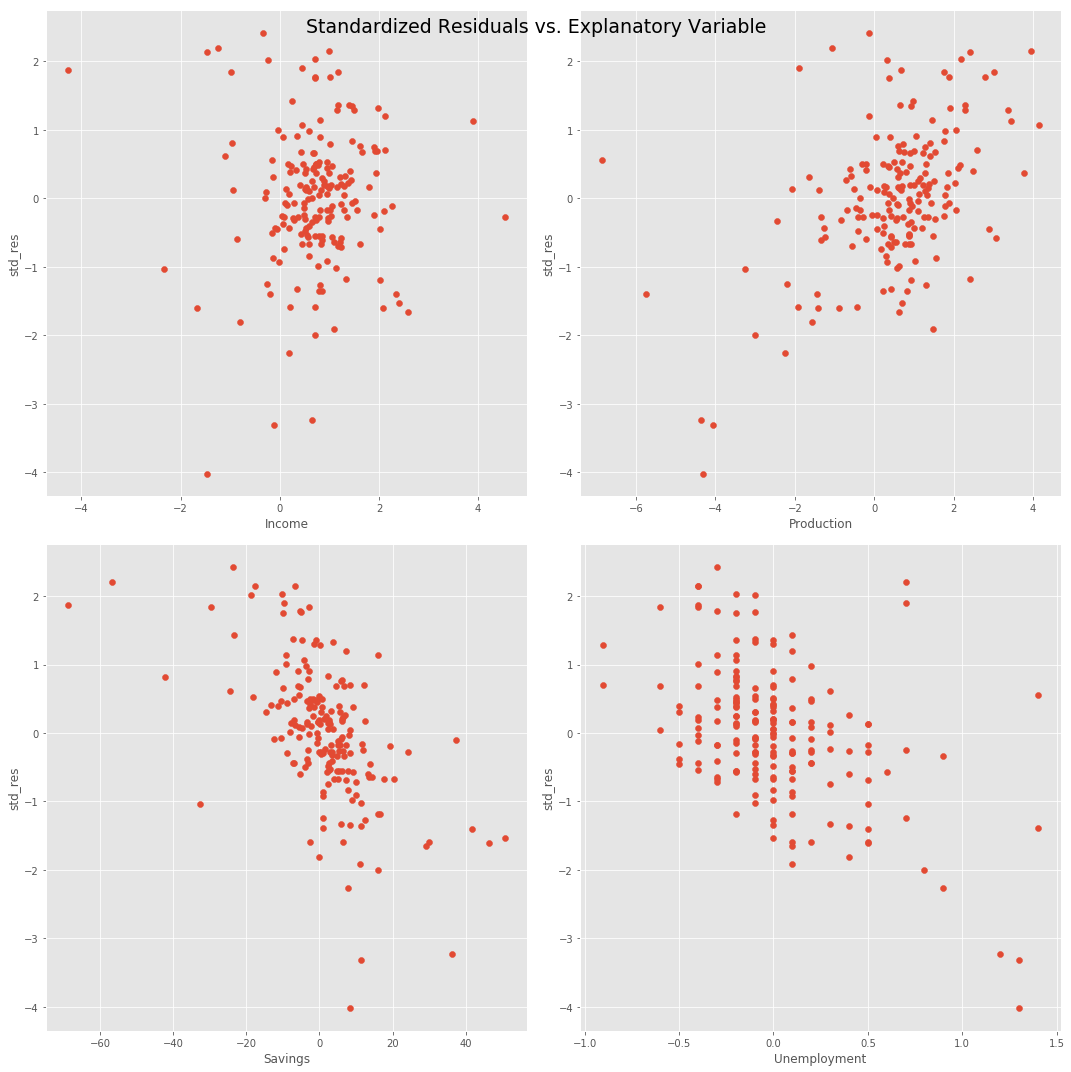

In [168]:
gm.plot_diagnostics()

## Outliers

**Influence DataFrame**

In [169]:
infl = gm.fitted.get_influence()

df_infl = infl.summary_frame()

df_infl[:5]

,dfb_const,dfb_g1,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
t,,,,,,,,
1970-03-31,-0.015336,-0.006740,0.000327,-0.336070,0.005749,-0.025556,-0.335263,-0.025495
1970-06-30,-0.024883,-0.024473,0.001572,-0.687257,0.006611,-0.056064,-0.686273,-0.055984
1970-09-30,-0.003072,-0.011453,0.000147,-0.173695,0.009676,-0.017169,-0.173239,-0.017124
1970-12-31,-0.131581,0.096262,0.008830,-1.247823,0.011214,-0.132888,-1.249716,-0.133090
1971-03-31,-0.004344,0.134134,0.013754,1.328948,0.015337,0.165857,1.331723,0.166204


**Leverage vs Studentized Residuals and Cook's distance**

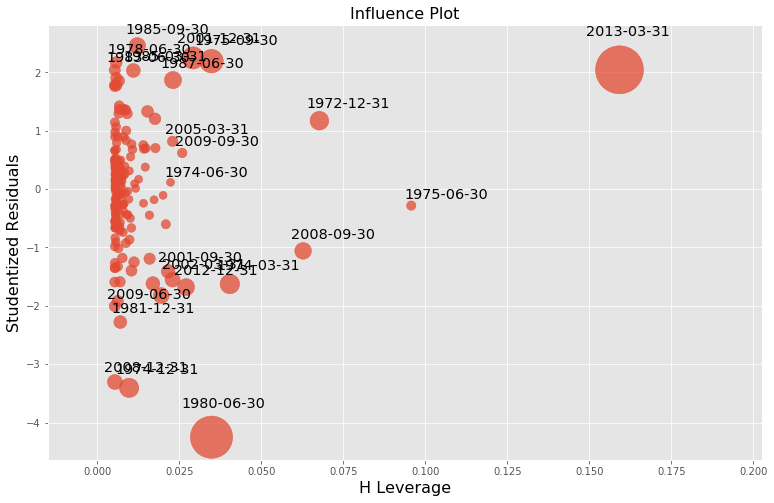

In [170]:
with mpl.rc_context():
    mpl.rc("figure", figsize=figsize)
    sm.graphics.influence_plot(gm.fitted)
    plt.show()

***

# Challenger Model: Robust Linear Regression

CV_error: 0.3247 +/- 0.1837


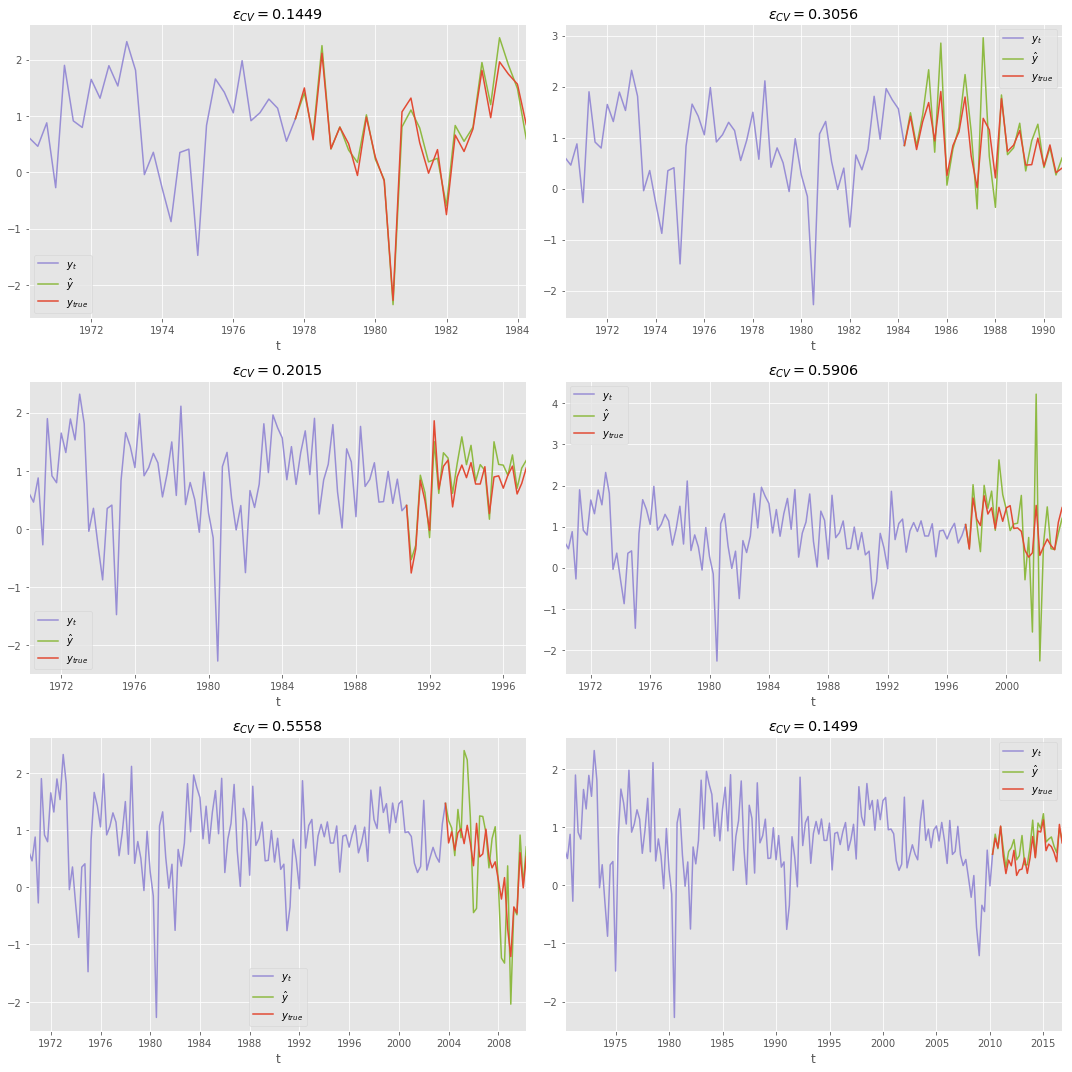

In [171]:
specification = ['const', 'g1', 'g3', 'g4']

gc = stb.GeneralCalibrator(sm.RLM, dict())
nDM = deepcopy(DM)

nDM.gX = nDM.gX[specification]
gm = stb.GeneralModel(gc, nDM)
cv = stb.CrossValidation(gm, splits, metric)
cv_m, cv_std = cv.run()

***

# Challenger Model: Weighted Least Squares

CV_error: 0.3050 +/- 0.1602


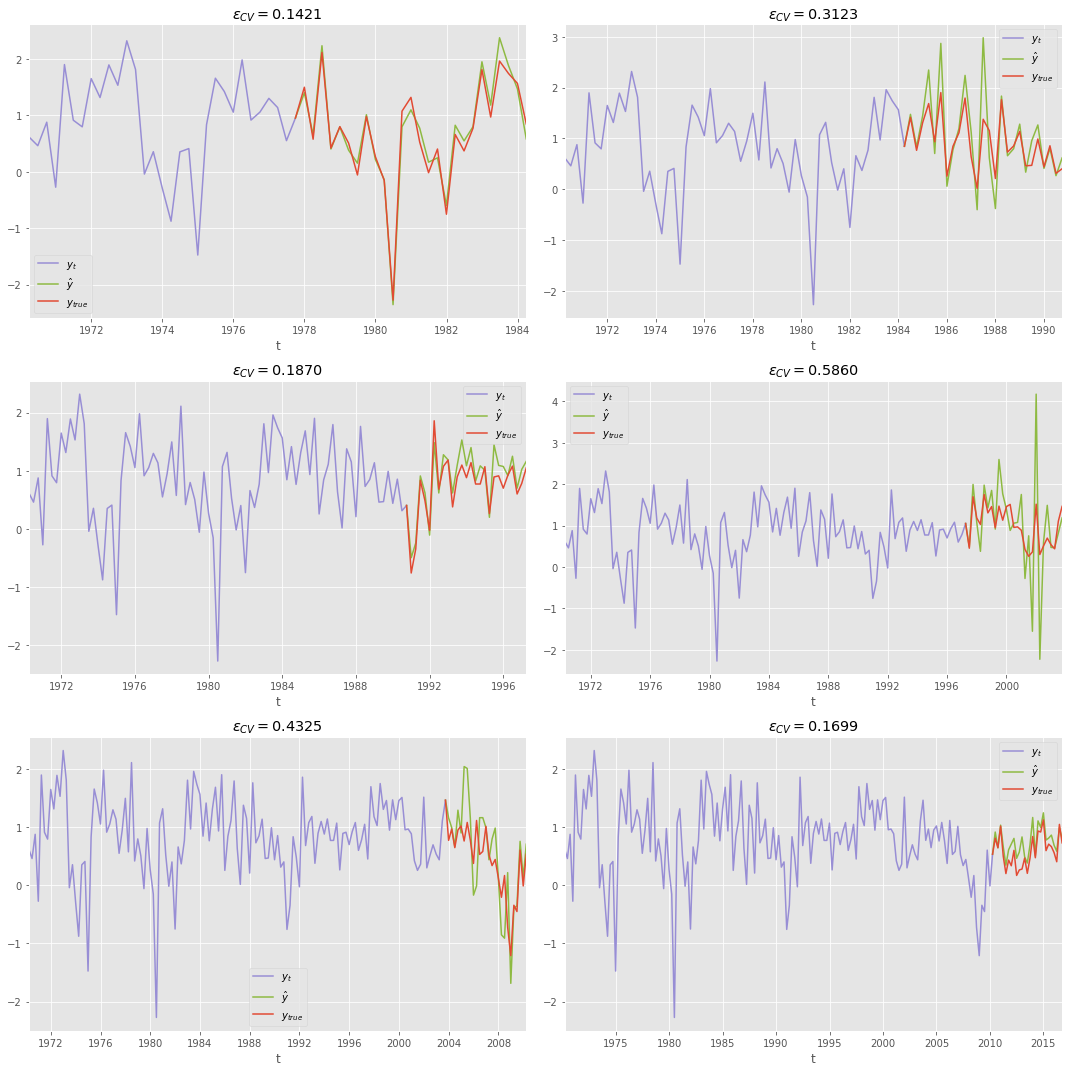

In [172]:
specification = ['const', 'g1', 'g3', 'g4']

gc = stb.GeneralCalibrator(sm.WLS, dict())
nDM = deepcopy(DM)

nDM.gX = nDM.gX[specification]
gm = stb.GeneralModel(gc, nDM)
cv = stb.CrossValidation(gm, splits, metric)
cv_m, cv_std = cv.run()